In [14]:
import pandas as pd

In [92]:
import sys
sys.path.append('/home/evlasova/mirpy')

In [96]:
from mir.common.clonotype_dataset import ClonotypeDataset
from mir.common.clonotype import ClonotypeAA

In [77]:
def get_sample_info(sample_name):
    data_path = f'/projects/immunestatus/pogorelyy/tcrempnet/{sample_name[:5]}'
    summary = pd.read_csv(f'{data_path}/yfv_{sample_name}_summary_tcrempnet.tsv', sep='\t')
    c0 = len(pd.read_csv(
        f'/projects/immunestatus/pogorelyy/airr_format/{sample_name.split('_')[0]}_0_F1{'_with_1_downsampled' if 'w' in sample_name else ''}.txt', sep='\t'))
    c15 = len(pd.read_csv(
        f'/projects/immunestatus/pogorelyy/airr_format/{sample_name.split('_')[0]}_15_F1.txt', sep='\t'))
    print(f'''
    sample: {sample_name}
    clusters: {len(summary)}
    overall from background: {c0}
    overall from sample: {c15}
    ''')
    return summary, c0, c15

In [183]:
vdjdb_df = pd.read_csv('../../data/vdjdb.slim.txt', sep='\t')

In [184]:
vdjdb_seqs = vdjdb_df[(vdjdb_df['antigen.species'] == 'YFV') & (vdjdb_df['gene'] == 'TRB')].cdr3
vdjdb_clonotypes = [ClonotypeAA(cdr3aa=x) for x in vdjdb_seqs]

In [186]:
vdjdb_df[(vdjdb_df['antigen.species'] == 'YFV') & (vdjdb_df['gene'] == 'TRB')]['mhc.a'].value_counts()

mhc.a
HLA-A*02:01             264
HLA-A*02                137
HLA-A*02,HLA-A*02:01      1
Name: count, dtype: int64

In [98]:
vdjdb = ClonotypeDataset(vdjdb_clonotypes)

In [99]:
vdjdb

A dataset of 402 clonotypes and 357 clusters

In [100]:
vdjdb.get_matching_clonotypes('CASSLAPGATNEQLFF')

set()

In [125]:
def get_clonotypes(sample_name):
    data_path = f'/projects/immunestatus/pogorelyy/tcrempnet/{sample_name[:5]}'
    df = pd.read_csv(f'{data_path}/yfv_{sample_name}_enriched_clonotypes_tcremp.tsv', sep='\t')
    return df

In [128]:
def has_vdjdb_match(x):
    return len(vdjdb.get_matching_clonotypes(x))

def get_cluster_matches_vdjdb(df, cluster_id):
    df = df[df.cluster_id == cluster_id]
    matches = df.cdr3aa_beta.apply(has_vdjdb_match)
    return sum(matches) > 0

In [131]:
samples = ['S1_F1', 'S2_F1', 'P1_F1', 'P2_F1', 'Q1_F1', 'Q2_F1']
sample_to_data = {}
sample_d_to_data = {}

for sample in samples:
    info = get_sample_info(sample)
    df = get_clonotypes(sample)
    info[0]['vdjdb'] = info[0].cluster_id.apply(lambda x: get_cluster_matches_vdjdb(df, x))
    sample_to_data[sample] = info
    
    try:
        info = get_sample_info(sample + '_with_1_downsampled')
        df = get_clonotypes(sample + '_with_1_downsampled')
        info[0]['vdjdb'] = info[0].cluster_id.apply(
            lambda x: get_cluster_matches_vdjdb(df, x))
        sample_d_to_data[sample] = info
    except Exception as e:
        print(e)


    sample: S1_F1
    clusters: 6986
    overall from background: 145713
    overall from sample: 139748
    

    sample: S1_F1_with_1_downsampled
    clusters: 11885
    overall from background: 350000
    overall from sample: 139748
    

    sample: S2_F1
    clusters: 12874
    overall from background: 264939
    overall from sample: 276172
    

    sample: S2_F1_with_1_downsampled
    clusters: 14582
    overall from background: 350000
    overall from sample: 276172
    

    sample: P1_F1
    clusters: 10445
    overall from background: 118243
    overall from sample: 311112
    

    sample: P1_F1_with_1_downsampled
    clusters: 15988
    overall from background: 350000
    overall from sample: 311112
    

    sample: P2_F1
    clusters: 12778
    overall from background: 161846
    overall from sample: 362331
    
[Errno 2] No such file or directory: '/projects/immunestatus/pogorelyy/tcrempnet/P2_F1/yfv_P2_F1_with_1_downsampled_summary_tcrempnet.tsv'

    sample: Q1_F1
  

In [132]:
sample_d_to_data['P2_F1'] = sample_to_data['P2_F1']

In [133]:
sample_to_data['S1_F1'][0]

,cluster_id,cluster_size,sample,background,enrichment_pvalue,vdjdb
0,0,6,3,3,0.636462,False
1,1,3,3,0,0.117325,False
2,2,6,5,1,0.099882,False
3,3,5,3,2,0.480415,False
4,4,16,12,4,0.031931,True
...,...,...,...,...,...,...
6981,6981,3,0,3,1.000000,False
6982,6982,3,0,3,1.000000,False
6983,6983,3,0,3,1.000000,False
6984,6984,3,2,1,0.484330,False


In [134]:
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact, chi2_contingency, binom
import matplotlib.pyplot as plt
import seaborn as sns

def compute_enrichment_pvalues(df, sample_overall, background_overall, method='fisher'):
    """
    df: DataFrame с колонками ['cluster_id', 'cluster_size', 'sample', 'background']
    sample_overall: общее число клонотипов в sample
    background_overall: общее число клонотипов в background
    method: 'fisher' | 'chi2' | 'binomial'
    """
    results = []

    for _, row in df.iterrows():
        cluster_id = row['cluster_id']
        a = row['sample']  # В кластере, из sample
        b = row['background']  # В кластере, из background
        c = sample_overall - a  # Вне кластера, из sample
        d = background_overall - b  # Вне кластера, из background

        if 'fisher' in method:
            _, pval = fisher_exact([[a, b], [c, d]])
        # elif method == 'chi2':
        #     _, pval, _, _ = chi2_contingency([[a, b], [c, d]])
        elif method == 'binomial':
            p = b / background_overall
            pval = min(binom.sf(k=a, n=sample_overall, p=p), binom.cdf(k=a, n=sample_overall, p=p))
        else:
            raise ValueError("method must be one of 'fisher', 'chi2', 'binomial'")

        fold_enrichment = (a / sample_overall) / ((b + 1e-9) / background_overall)
        results.append({'cluster_id': cluster_id, 'pvalue': pval, 'fold_enrichment': fold_enrichment})

    return pd.DataFrame(results)


In [174]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_volcano(df, pval_threshold=0.05, fold_threshold=2, ax=None):
    df = df.copy()

    if 'vdjdb' not in df.columns:
        raise ValueError("DataFrame должен содержать колонку 'vdjdb'")

    # Преобразования
    df['log10_pval'] = -np.log10(df['pvalue'] + 1e-10)
    df['log2_fc'] = np.log2(df['fold_enrichment'] + 1e-5)
    df['significant'] = (df['pvalue'] < pval_threshold) & (df['fold_enrichment'] > fold_threshold)
    

    # Цветовая кодировка
    def assign_color(row):
        if row['significant'] and row['vdjdb']:
            return 'sign_vdjdb' #'#084594'  # тёмно-синий
        elif row['significant']:
            return 'sign'#'#4292c6'  # голубой
        elif row['vdjdb']:
            return 'vdjdb'#'#fdbb84'  # оранжевый
        else:
            return 'no'#'#ffffb2'  # бледно-жёлтый
    
    colors = {
        'sign_vdjdb': '#084594',  # тёмно-синий
        'sign': '#4292c6',  # голубой
        'vdjdb': '#fdbb84',  # оранжевый
        'no': '#ffffb2'  # бледно-жёлтый
    }
    
    df['label'] = df.apply(assign_color, axis=1)

    # Порог Бонферрони
    bonferroni_thresh = pval_threshold / len(df)
    log10_bonferroni = -np.log10(bonferroni_thresh)
    num_significant = df['significant'].sum()
    num_significant_bonf = (df['pvalue'] < bonferroni_thresh).sum()

    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # Отрисовка
    sns.scatterplot(
        data=df,
        x='log2_fc',
        y='log10_pval',
        hue='label',
        style='vdjdb',
        palette=colors,
        markers={True: 's', False: '.'},
        edgecolor='black',
        linewidth=0.3,
        ax=ax,
        s=70,
        alpha=0.85,
    )

    # Линии порогов
    ax.axvline(np.log2(fold_threshold), ls='--', color='black')
    ax.axhline(-np.log10(pval_threshold), ls='--', color='black')
    ax.axhline(log10_bonferroni, ls=':', color='blue')

    ax.set_xlabel('log2(Fold Enrichment)')
    ax.set_ylabel('-log10(p-value)')
    ax.set_title(f'Significant clusters: {num_significant}, after Bonferroni: {num_significant_bonf}')
    ax.legend()

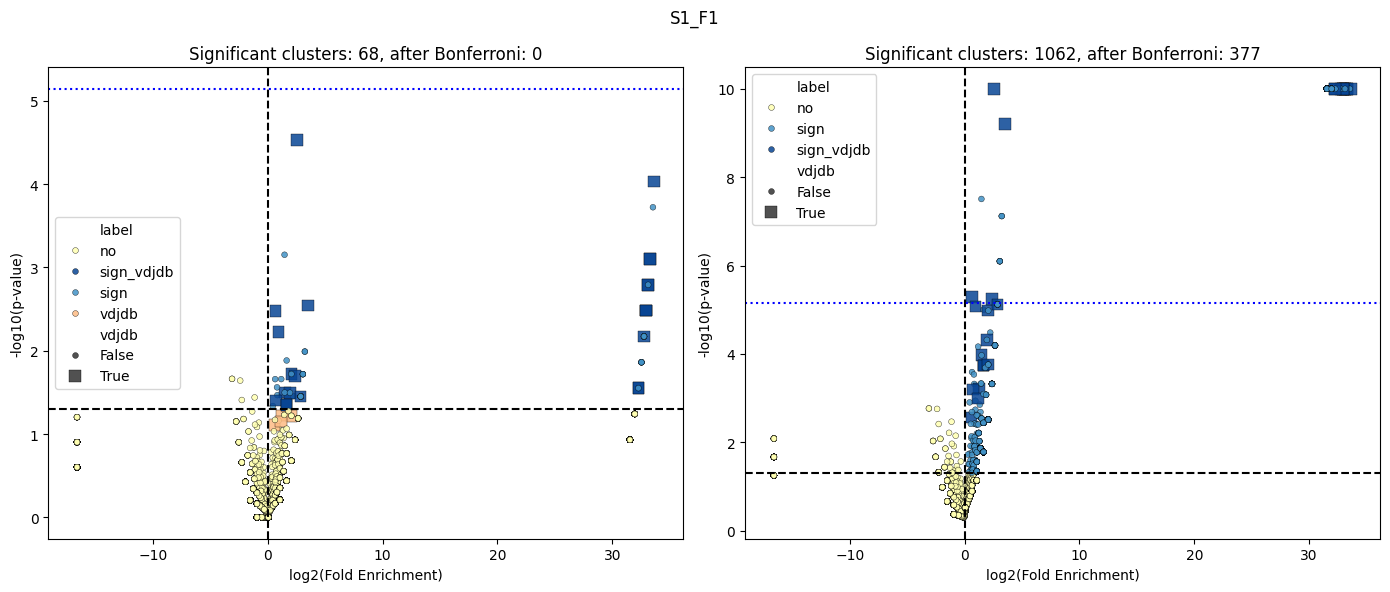

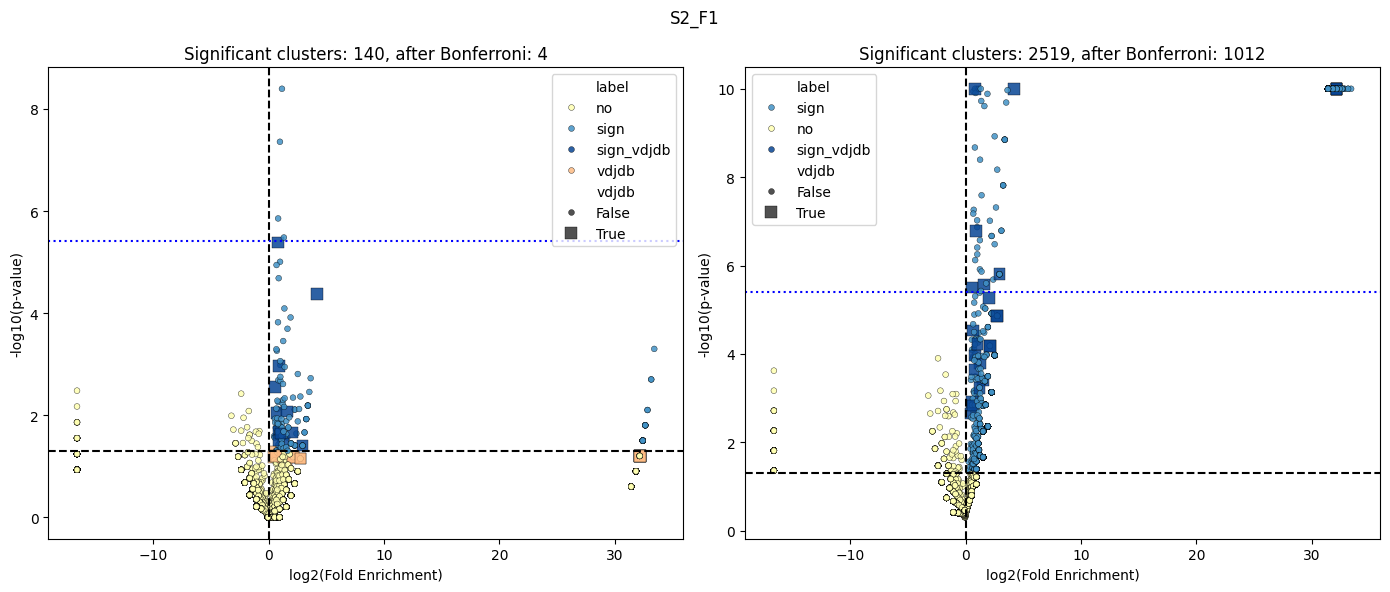

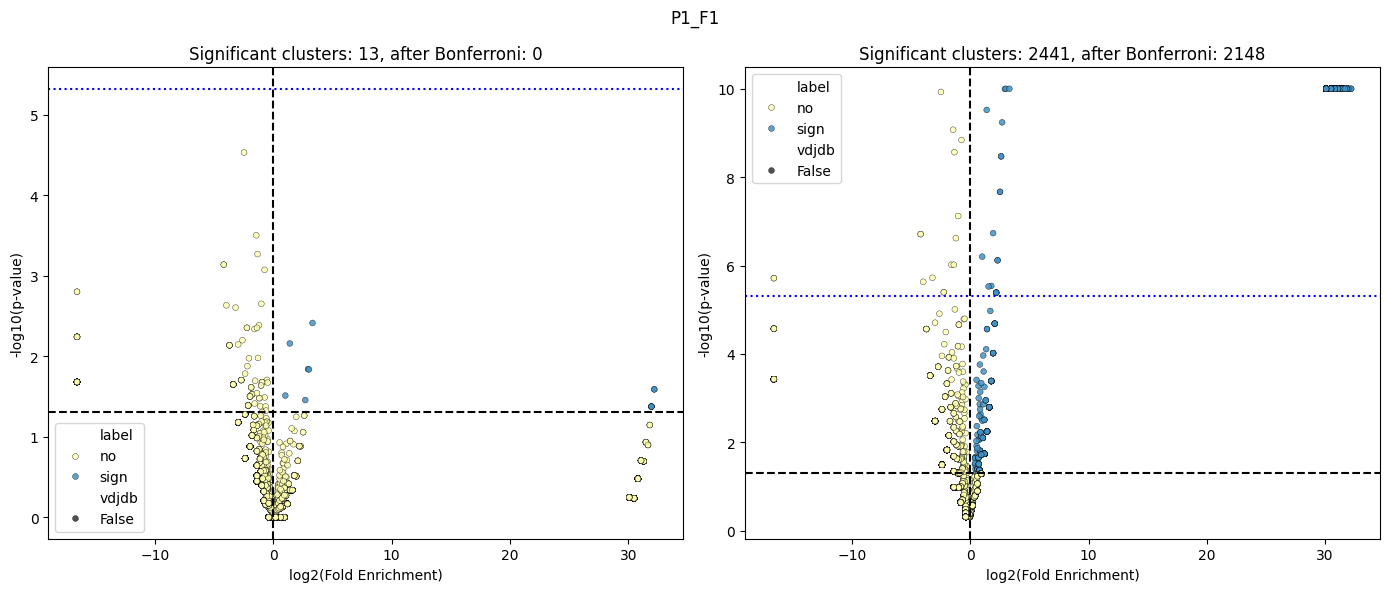

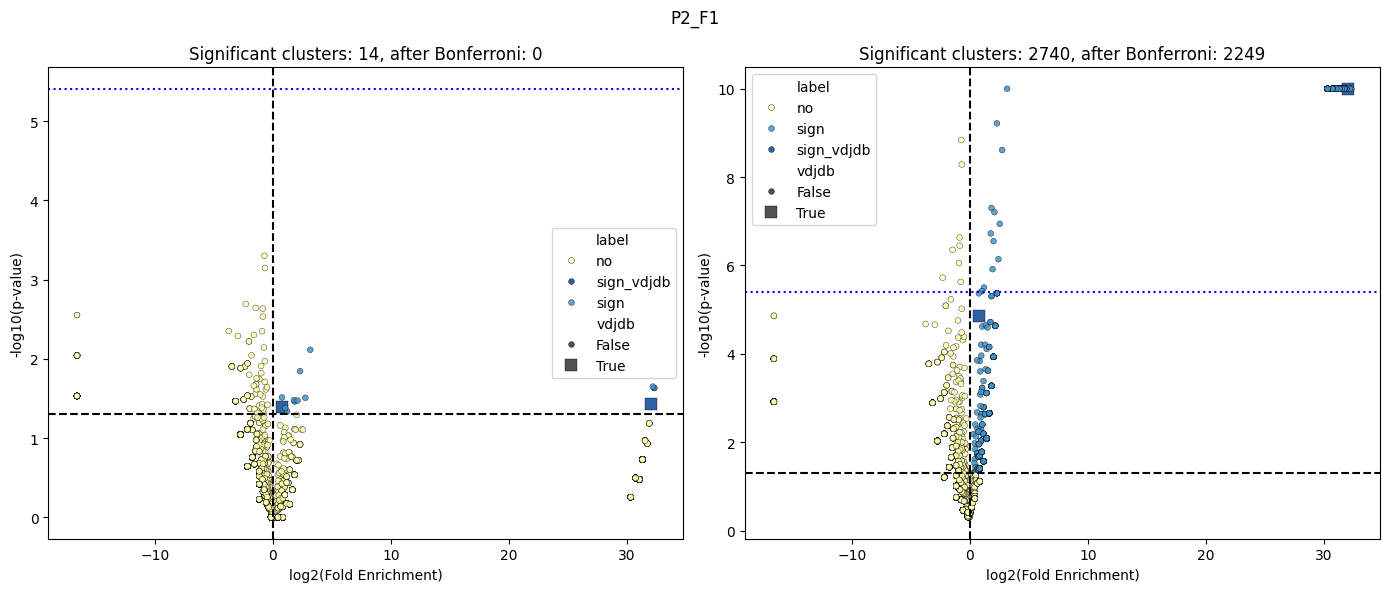

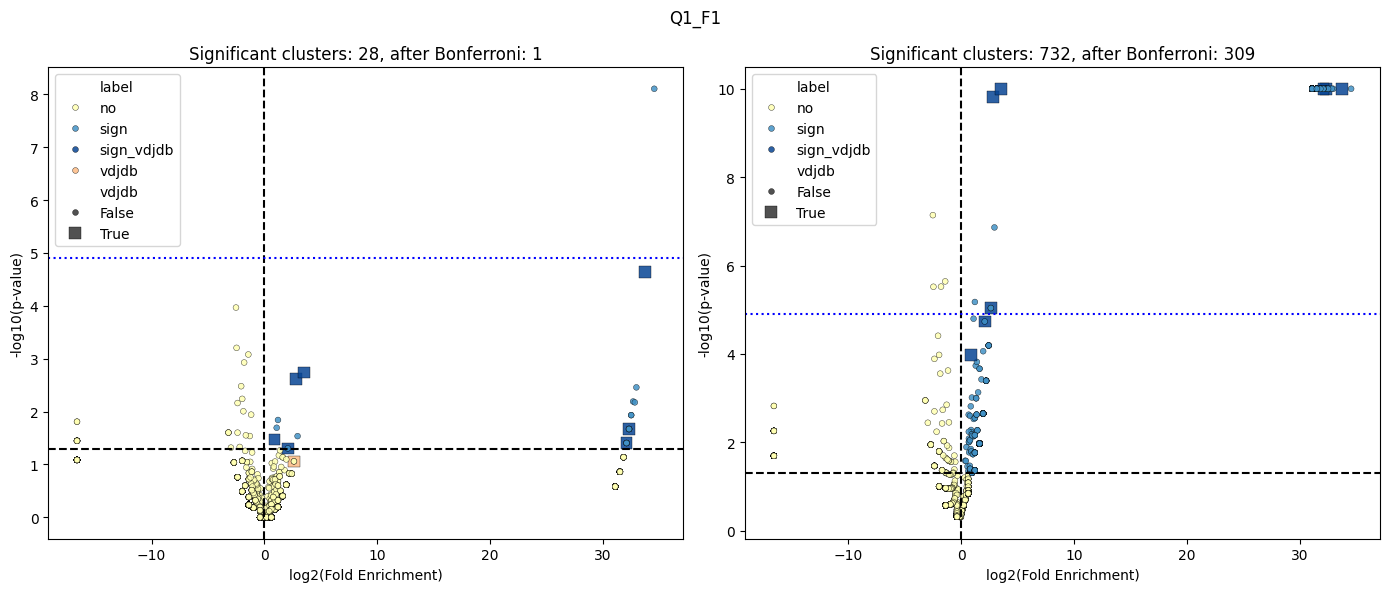

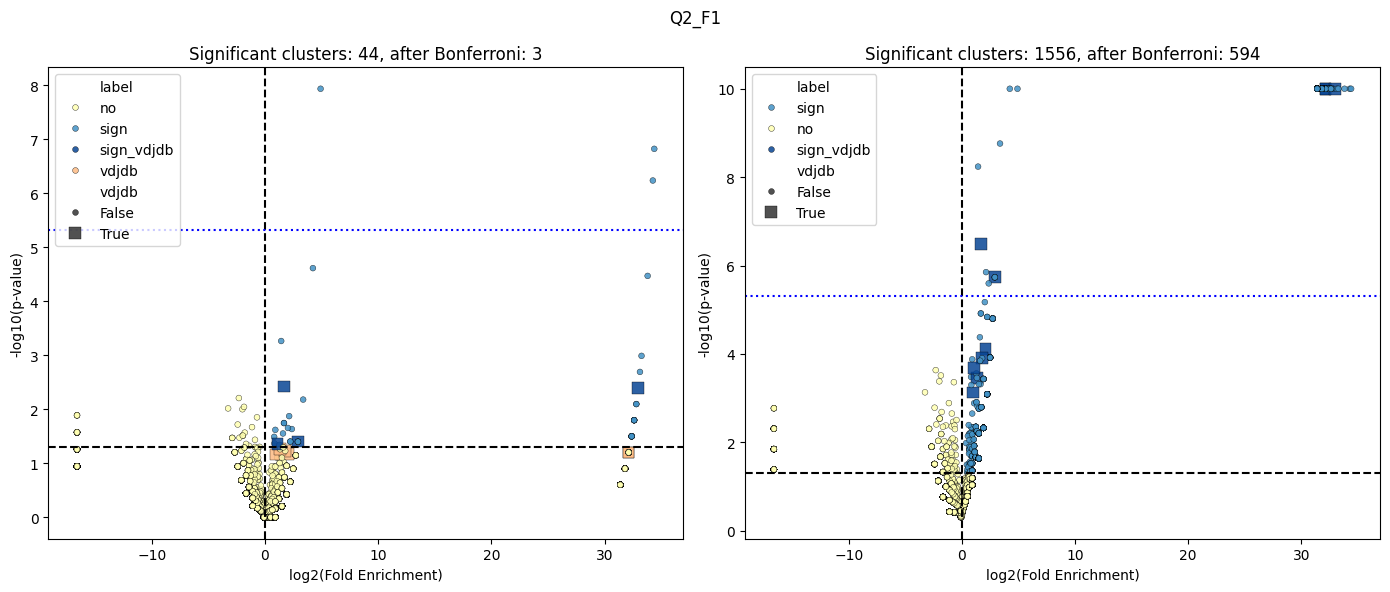

In [175]:
import matplotlib.pyplot as plt

for s in samples:
    methods = ['fisher-all', 'binomial']
    fig, axes = plt.subplots(1, len(methods), figsize=(7 * len(methods), 6))

    s1_res = sample_to_data[s]

    for ax, method in zip(axes, methods):
        res_df = compute_enrichment_pvalues(
            s1_res[0],
            sample_overall=s1_res[2],
            background_overall=s1_res[1],
            method=method
        )
        res_df['vdjdb'] = s1_res[0].vdjdb
        plot_volcano(res_df, ax=ax, fold_threshold=1)
    plt.suptitle(s)
    plt.tight_layout()
    plt.show()

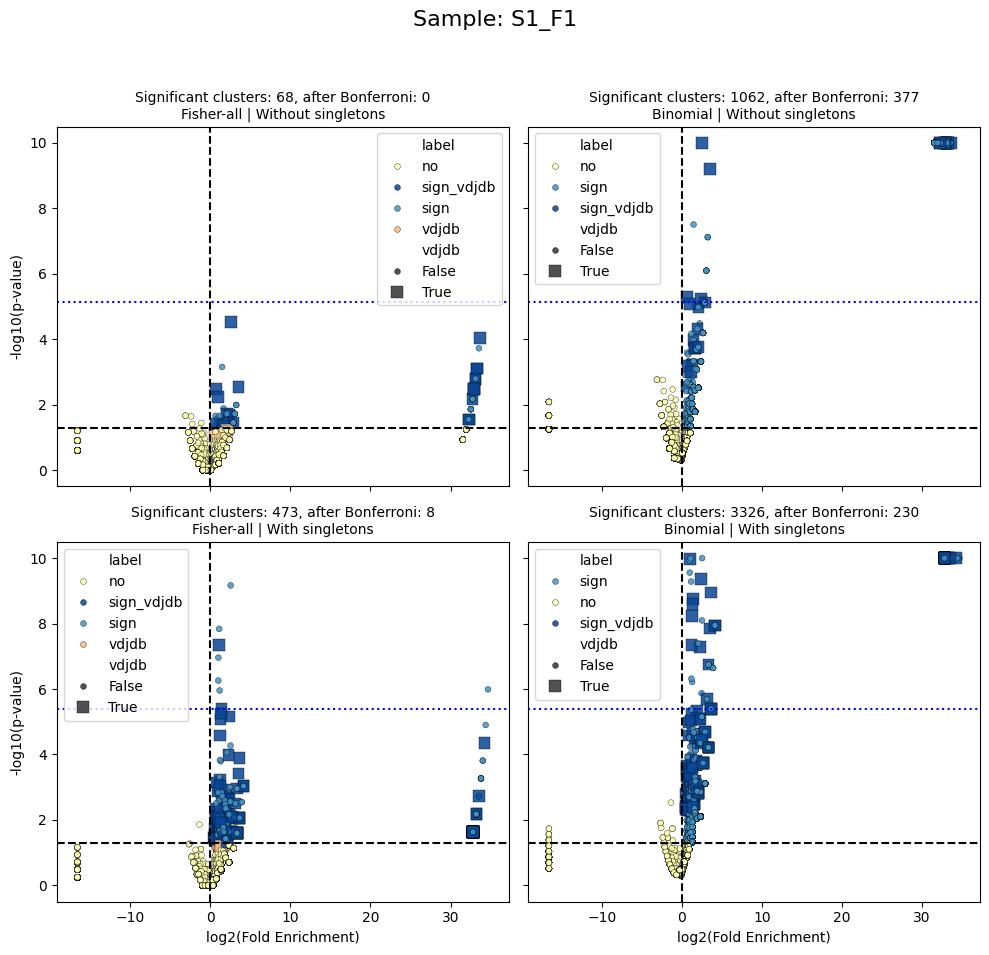

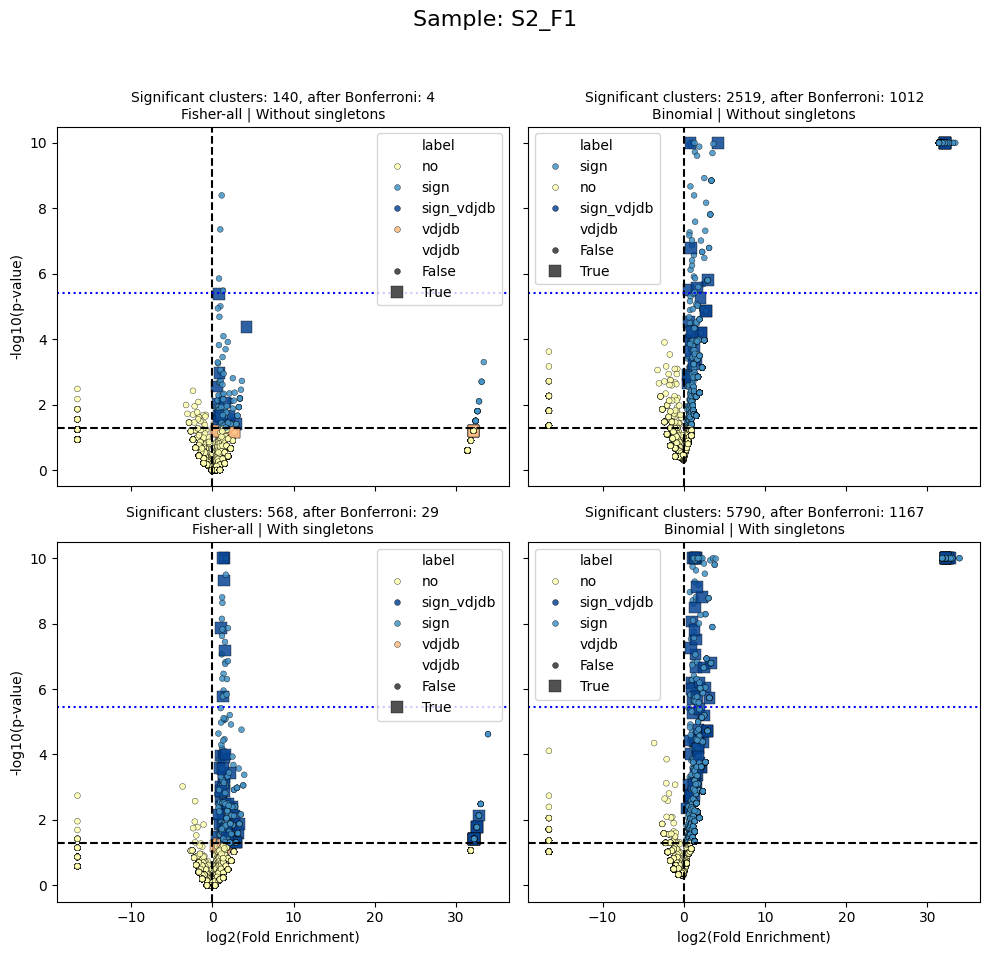

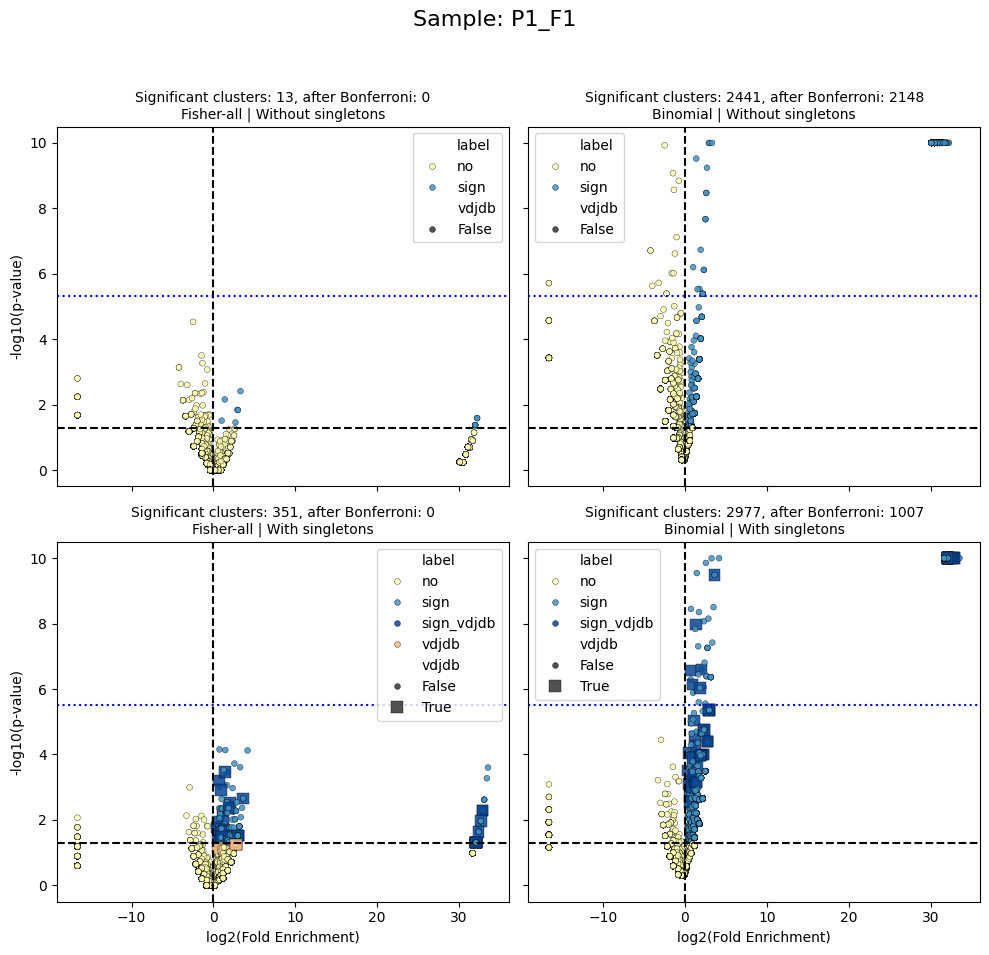

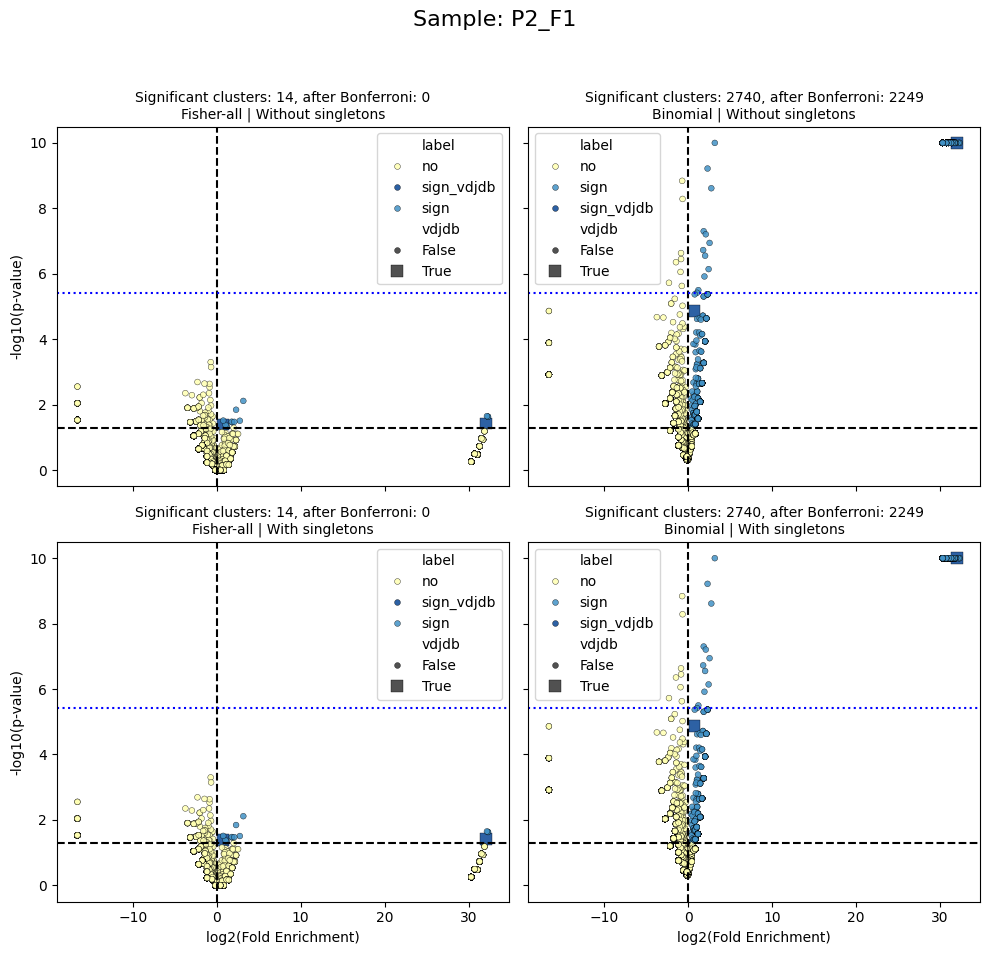

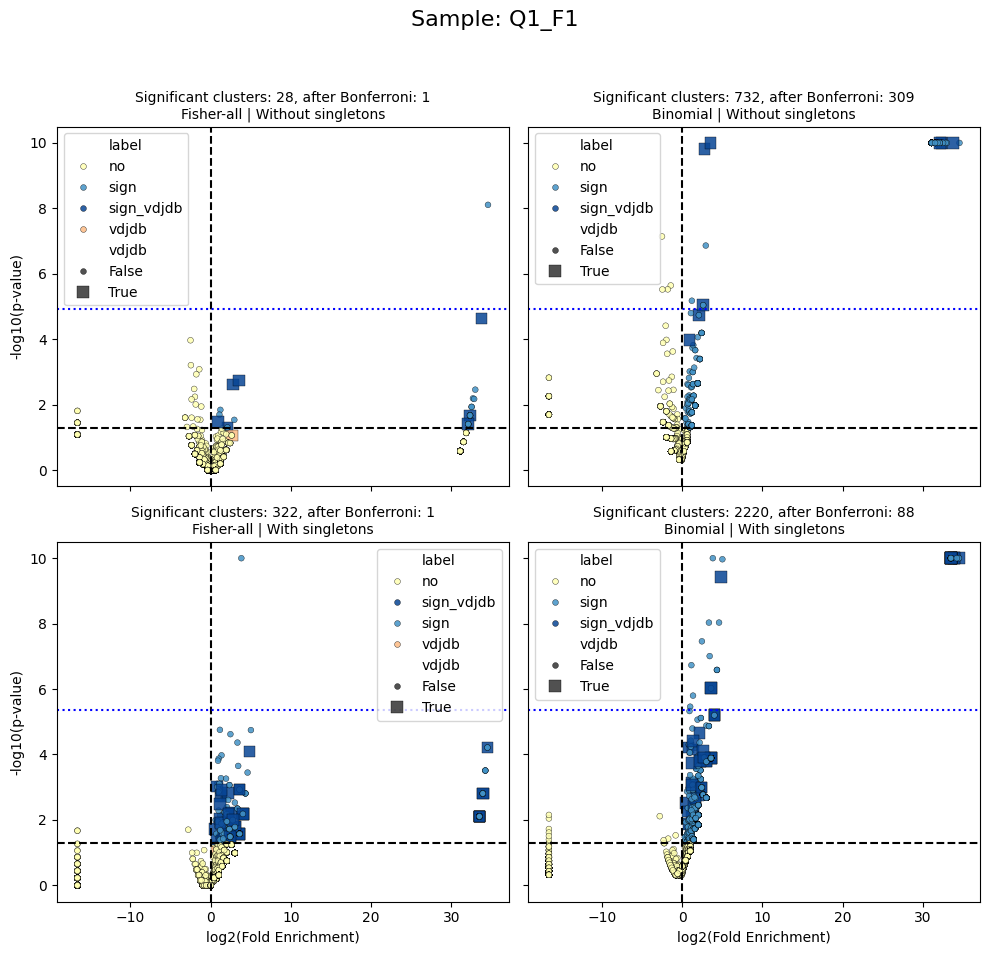

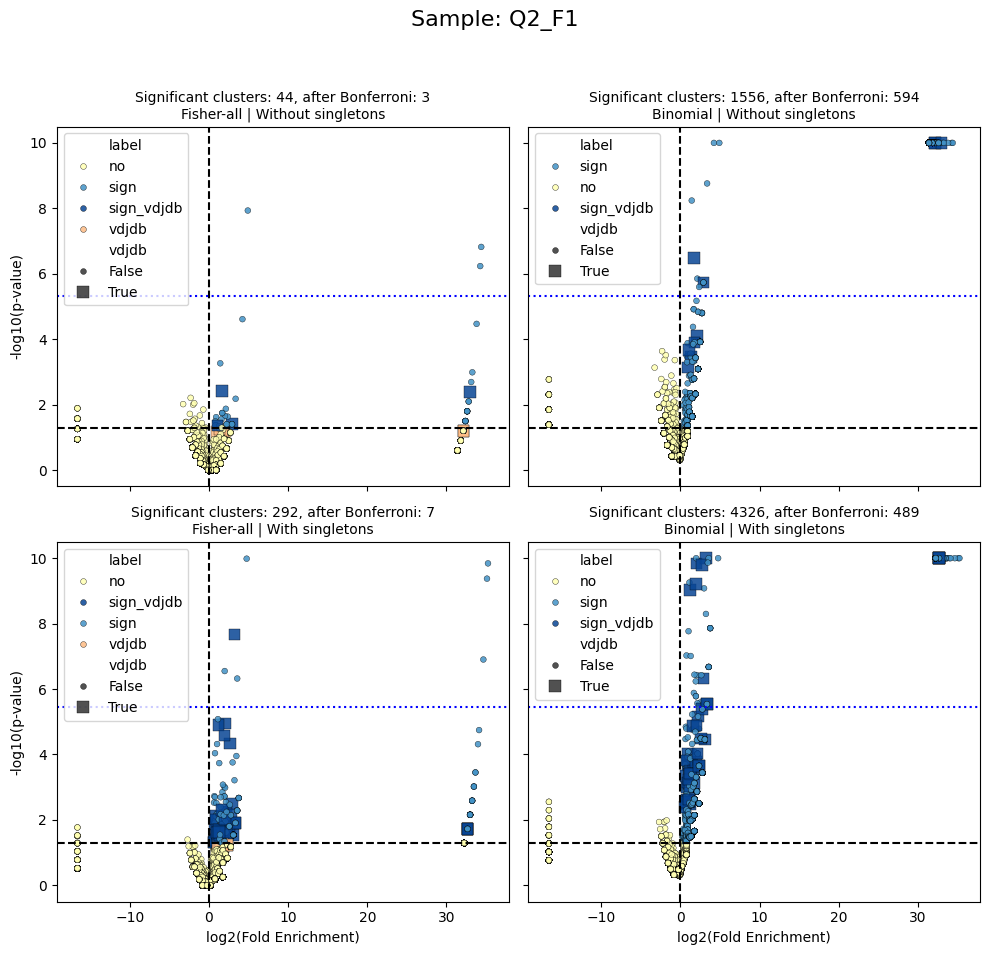

In [188]:
import matplotlib.pyplot as plt

methods = ['fisher-all', 'binomial']
sampling_sets = ['sample_to_data', 'sample_to_d_data']
sampling_titles = ['Without singletons', 'With singletons']
sampling_dicts = [sample_to_data, sample_d_to_data]

for s in samples:
    fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

    for i, (sampling_title, data_dict) in enumerate(zip(sampling_titles, sampling_dicts)):
        s_res = data_dict[s]
        for j, method in enumerate(methods):
            ax = axes[i, j]
            res_df = compute_enrichment_pvalues(
                s_res[0],
                sample_overall=s_res[2],
                background_overall=s_res[1],
                method=method.replace("-all", "")  # remove -all for compatibility
            )
            res_df['vdjdb'] = s_res[0].vdjdb
            plot_volcano(res_df, ax=ax, fold_threshold=1)

            # Не перезаписываем, а дописываем
            old_title = ax.get_title()
            ax.set_title(f"{old_title}\n{method.capitalize()} | {sampling_title}", fontsize=10)
            
    plt.suptitle(f'Sample: {s}', fontsize=16)
    plt.savefig(f'cluster_volcanos/{s}.png', dpi=300)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()